In [33]:
import pandas as pd
import numpy as np
from sklearn.cluster import SpectralClustering, SpectralBiclustering, SpectralCoclustering
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, "..")   
from src.gdkm import compute_gdkm_cv_scores, suggest_optimal_pq
from src.plot_util import visualize_gdkm_cv_scores, plot_gdkm_elbow_curve, plot_biclustering_elbow, plot_spectral_clustering_elbows  
from src.utils import preprocess_sales_matrix, compute_spectral_clustering_cv_scores



In [7]:
%load_ext autoreload
%autoreload 2

In [64]:
today_str = datetime.today().strftime("%Y-%m-%d")
today_str

'2025-06-04'

In [1]:
# load
dtype_dict={"id":np.uint32,
            "store_nbr":np.uint8,
            "item_nbr":np.uint32,
            "unit_sales":np.float32
           }
df = pd.read_csv("../output/data/train_top_10_store_10_item.csv", dtype=dtype_dict)
cols = ['date', 'store_item', 'store_nbr', 'item_nbr'] + [c for c in df.columns 
                                  if c not in ('date', 'store_item', 'store_nbr', 'item_nbr')]
df = df[cols]
df.rename(columns={"store_nbr": "store", "item_nbr": "item"}, inplace=True)
df["date"] = pd.to_datetime(df["date"])
df.sort_values("date", inplace=True)
df.reset_index(drop=True, inplace=True)
df.head(5)


/var/folders/w3/d06m5l_97yn4bnxd5t6cgbjr0000gn/T/ipykernel_74514/3612587674.py:7: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../output/data/train_top_10_store_10_item.csv", dtype=dtype_dict)


,date,store_item,store,item,unit_sales,onpromotion
0,2013-01-07,48_502331,48,502331,70.00000,NaN
1,2013-01-07,46_584028,46,584028,304.27301,NaN
2,2013-01-07,3_114790,3,114790,28.00000,NaN
3,2013-01-07,3_305229,3,305229,89.00000,NaN
4,2013-01-07,3_314384,3,314384,106.00000,NaN


In [2]:
df['onpromotion'].unique()

array([nan, False, True], dtype=object)

In [3]:
df["date"] = pd.to_datetime(df["date"])
df["dayofweek"] = df["date"].dt.dayofweek
df["month"] = df["date"].dt.month
df["weekofyear"] = df["date"].dt.isocalendar().week
df

,date,store_item,store,item,unit_sales,onpromotion,dayofweek,month,weekofyear
0,2013-01-07,48_502331,48,502331,70.00000,NaN,0,1,2
1,2013-01-07,46_584028,46,584028,304.27301,NaN,0,1,2
2,2013-01-07,3_114790,3,114790,28.00000,NaN,0,1,2
3,2013-01-07,3_305229,3,305229,89.00000,NaN,0,1,2
4,2013-01-07,3_314384,3,314384,106.00000,NaN,0,1,2
...,...,...,...,...,...,...,...,...,...
167299,2017-08-15,51_567623,51,567623,17.00000,False,1,8,33
167300,2017-08-15,51_581078,51,581078,30.00000,False,1,8,33
167301,2017-08-15,49_567623,49,567623,29.00000,False,1,8,33
167302,2017-08-15,49_502331,49,502331,61.00000,False,1,8,33


In [4]:

# Example: aggregate by dayofweek
clust_df = df.groupby(["store_item", "dayofweek"])["unit_sales"].sum().unstack(fill_value=0)
clust_df

dayofweek,0,1,2,3,4,5,6
store_item,,,,,,,
3_1047679,104473.000000,94406.000000,96164.000000,82776.000000,96191.000000,127381.000000,142048.000000
3_114790,6080.000000,5583.000000,6211.000000,4908.000000,5764.000000,7905.000000,8928.000000
3_305229,15900.000000,13750.000000,17093.000000,12586.000000,14852.000000,16053.000000,16819.000000
3_314384,22721.000000,20674.000000,23415.000000,17440.000000,21586.000000,29785.000000,33913.000000
3_364606,25960.000000,24294.000000,26153.000000,20437.000000,22594.000000,29208.000000,31280.000000
...,...,...,...,...,...,...,...
8_502331,11372.000000,9348.000000,9652.000000,7945.000000,9495.000000,12454.000000,15433.000000
8_567623,4441.000000,3879.000000,3941.000000,3181.000000,3373.000000,5589.000000,6786.000000
8_581078,3476.000000,3495.000000,3810.000000,3304.000000,3536.000000,3793.000000,3585.000000


In [11]:
X, pivot_clean = preprocess_sales_matrix(clust_df, log_transform=True, smooth_window=16, zscore_rows=True)

/Users/yvesgreatti/github/kaggle_favorita_grocery_sales_forecasting/notebook/../src/utils.py:393: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  df = df.rolling(window=smooth_window, axis=1, min_periods=1).mean()


In [12]:
pivot_clean

dayofweek,0,1,2,3,4,5,6
store_item,,,,,,,
3_1047679,11.556693,11.506032,11.495295,11.452448,11.456778,11.506473,11.557538
3_114790,8.712924,8.670292,8.691608,8.643412,8.646642,8.701431,8.757949
3_305229,9.674137,9.601502,9.649829,9.597477,9.599173,9.613263,9.629986
3_314384,10.031089,9.983885,10.009648,9.948881,9.955074,10.012861,10.072678
3_364606,10.164351,10.131188,10.144711,10.089821,10.076954,10.111167,10.145395
...,...,...,...,...,...,...,...
8_502331,9.338998,9.241011,9.219015,9.159368,9.159219,9.204329,9.267186
8_567623,8.398860,8.331225,8.313965,8.251790,8.226203,8.293292,8.368931
8_581078,8.153925,8.156650,8.186316,8.165534,8.166634,8.179058,8.179877


In [14]:
pivot_clean.index.nunique()

100

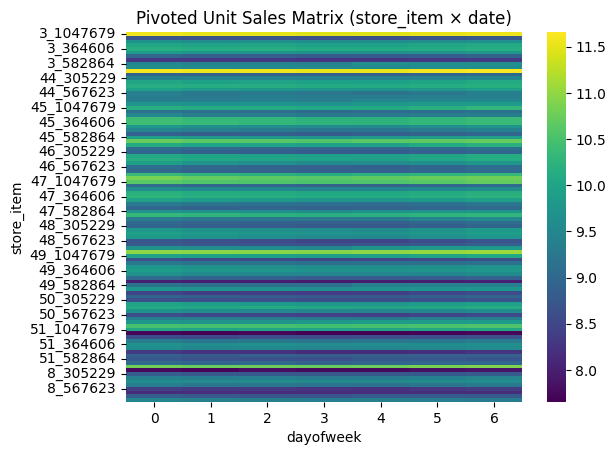

In [13]:
sns.heatmap(pivot_clean, cmap="viridis")
plt.title("Pivoted Unit Sales Matrix (store_item × date)")
plt.show()

In [15]:
pivot_clean.shape

(100, 7)

In [31]:
results_spectral_clustering = compute_spectral_clustering_cv_scores(
    data=pivot_clean.values,
    model_class=SpectralClustering,
    n_clusters_row_range=range(10, 50),
    cv_folds=3
)
results_spectral_clustering


Evaluating n_row=10
Evaluating n_row=11
Evaluating n_row=12
Evaluating n_row=13
Evaluating n_row=14
Evaluating n_row=15
Evaluating n_row=16
Evaluating n_row=17
Evaluating n_row=18
Evaluating n_row=19
Evaluating n_row=20
Evaluating n_row=21
Evaluating n_row=22
Evaluating n_row=23
Evaluating n_row=24
Evaluating n_row=25
Evaluating n_row=26
Evaluating n_row=27
Evaluating n_row=28
Evaluating n_row=29
Evaluating n_row=30
Evaluating n_row=31
Evaluating n_row=32
Evaluating n_row=33
Evaluating n_row=34
Evaluating n_row=35
Evaluating n_row=36
Evaluating n_row=37
Evaluating n_row=38
Evaluating n_row=39
Evaluating n_row=40
Evaluating n_row=41
Evaluating n_row=42
Evaluating n_row=43
Evaluating n_row=44
Evaluating n_row=45
Evaluating n_row=46
Evaluating n_row=47
Evaluating n_row=48
Evaluating n_row=49


,n_row,n_col,Explained Variance (%),Mean Silhouette,Mean ARI
0,10,NaN,96.278016,0.444541,NaN
1,11,NaN,96.491341,0.455114,NaN
2,12,NaN,96.724324,0.452682,NaN
3,13,NaN,96.907628,0.339216,NaN
4,14,NaN,97.048360,0.401238,NaN
5,15,NaN,96.967188,0.355693,NaN
6,16,NaN,97.067414,0.317863,NaN
7,17,NaN,97.430530,0.350560,NaN
8,18,NaN,97.198594,0.337446,NaN
9,19,NaN,97.157988,0.234152,NaN


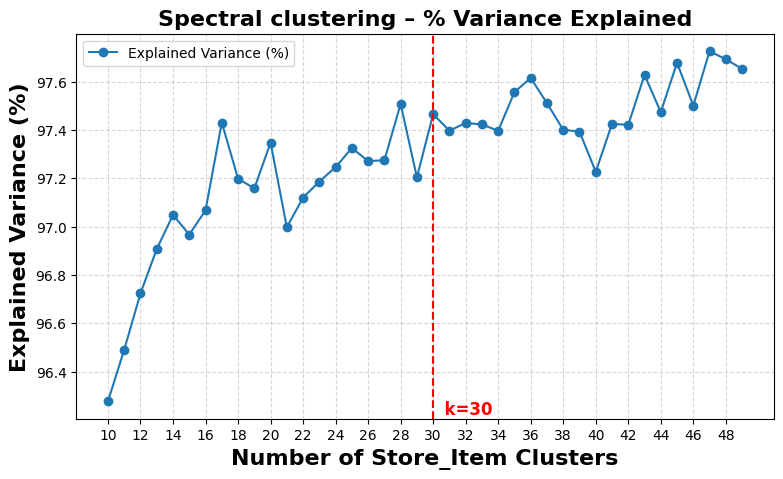

In [32]:
plot_biclustering_elbow(results_spectral_clustering, 
                        title="Spectral clustering – % Variance Explained", 
                        x_col="n_row", 
                        metric="Explained Variance (%)", 
                        tick_step=2,
                        vline_x=30,
                        title_fontsize=16,
                        fn="../output/figures/20250607_spectral_clustering_elbow.tiff")

In [29]:
results_spectral_biclustering = compute_spectral_clustering_cv_scores(
    data=pivot_clean.values,
    model_class=SpectralBiclustering,
    n_clusters_row_range=range(10, 50),   
    cv_folds=3
)
results_spectral_biclustering

Evaluating n_row=10
Evaluating n_row=10
Evaluating n_row=10
Evaluating n_row=10
Evaluating n_row=11
Evaluating n_row=11
Evaluating n_row=11
Evaluating n_row=11
Evaluating n_row=12
Evaluating n_row=12
Evaluating n_row=12
Evaluating n_row=12
Evaluating n_row=13
Evaluating n_row=13
Evaluating n_row=13
Evaluating n_row=13
Evaluating n_row=14
Evaluating n_row=14
Evaluating n_row=14
Evaluating n_row=14
Evaluating n_row=15
Evaluating n_row=15
Evaluating n_row=15
Evaluating n_row=15
Evaluating n_row=16
Evaluating n_row=16
Evaluating n_row=16
Evaluating n_row=16
Evaluating n_row=17
Evaluating n_row=17
Evaluating n_row=17
Evaluating n_row=17
Evaluating n_row=18
Evaluating n_row=18
Evaluating n_row=18
Evaluating n_row=18
Evaluating n_row=19
Evaluating n_row=19
Evaluating n_row=19
Evaluating n_row=19
Evaluating n_row=20
Evaluating n_row=20
Evaluating n_row=20
Evaluating n_row=20
Evaluating n_row=21
Evaluating n_row=21
Evaluating n_row=21
Evaluating n_row=21
Evaluating n_row=22
Evaluating n_row=22


,n_row,n_col,Explained Variance (%),Mean Silhouette,Mean ARI
0,10,NaN,69.264125,0.147572,NaN
1,10,NaN,67.061729,0.168783,NaN
2,10,NaN,72.711757,0.154879,NaN
3,10,NaN,72.711757,0.154879,NaN
4,11,NaN,73.445542,0.125998,NaN
...,...,...,...,...,...
155,48,NaN,98.087023,0.175858,NaN
156,49,NaN,98.192240,0.193231,NaN
157,49,NaN,95.740693,0.152852,NaN
158,49,NaN,98.007359,0.176485,NaN


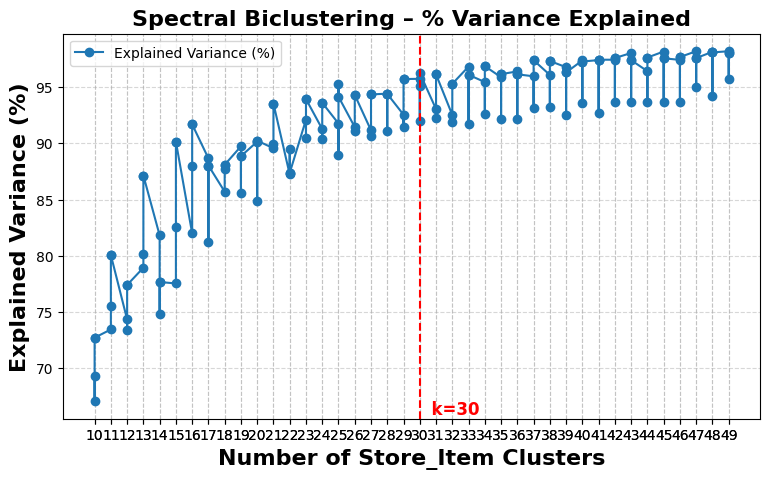

In [30]:
plot_biclustering_elbow(results_spectral_biclustering, 
                        title="Spectral Biclustering – % Variance Explained", 
                        x_col="n_row", 
                        metric="Explained Variance (%)", 
                        tick_step=2,
                        vline_x=30,
                        title_fontsize=16,
                        fn="../output/figures/20250607_spectral_biclustering_elbow.tiff")

In [26]:
results_spectral_coclustering = compute_spectral_clustering_cv_scores(
    data=pivot_clean.values,
    model_class=SpectralCoclustering,
    n_clusters_row_range=range(10, 50),  
    cv_folds=3
)
results_spectral_coclustering

Evaluating n_row=10
Evaluating n_row=11
Evaluating n_row=12
Evaluating n_row=13
Evaluating n_row=14
Evaluating n_row=15
Evaluating n_row=16
Evaluating n_row=17
Evaluating n_row=18
Evaluating n_row=19
Evaluating n_row=20
Evaluating n_row=21
Evaluating n_row=22
Evaluating n_row=23
Evaluating n_row=24
Evaluating n_row=25
Evaluating n_row=26
Evaluating n_row=27
Evaluating n_row=28
Evaluating n_row=29
Evaluating n_row=30
Evaluating n_row=31
Evaluating n_row=32
Evaluating n_row=33
Evaluating n_row=34
Evaluating n_row=35
Evaluating n_row=36
Evaluating n_row=37
Evaluating n_row=38
Evaluating n_row=39
Evaluating n_row=40
Evaluating n_row=41
Evaluating n_row=42
Evaluating n_row=43
Evaluating n_row=44
Evaluating n_row=45
Evaluating n_row=46
Evaluating n_row=47
Evaluating n_row=48
Evaluating n_row=49


,n_row,n_col,Explained Variance (%),Mean Silhouette,Mean ARI
0,10,NaN,76.169455,0.222639,NaN
1,11,NaN,74.579020,0.307576,NaN
2,12,NaN,79.307965,0.265818,NaN
3,13,NaN,86.064196,0.222330,NaN
4,14,NaN,84.303359,0.303804,NaN
5,15,NaN,83.292344,0.264974,NaN
6,16,NaN,90.134983,0.278780,NaN
7,17,NaN,81.487539,0.147911,NaN
8,18,NaN,85.828599,0.102020,NaN
9,19,NaN,91.304067,0.281969,NaN


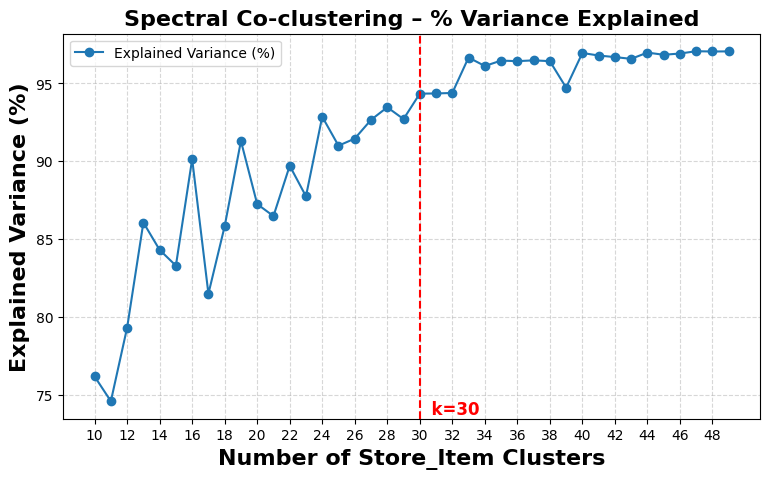

In [27]:
plot_biclustering_elbow(results_spectral_coclustering, 
                        title="Spectral Co-clustering – % Variance Explained", 
                        x_col="n_row", 
                        metric="Explained Variance (%)", 
                        tick_step=2,
                        vline_x=30,
                        title_fontsize=16,
                        fn="../output/figures/20250607_spectral_coclustering_elbow.tiff")

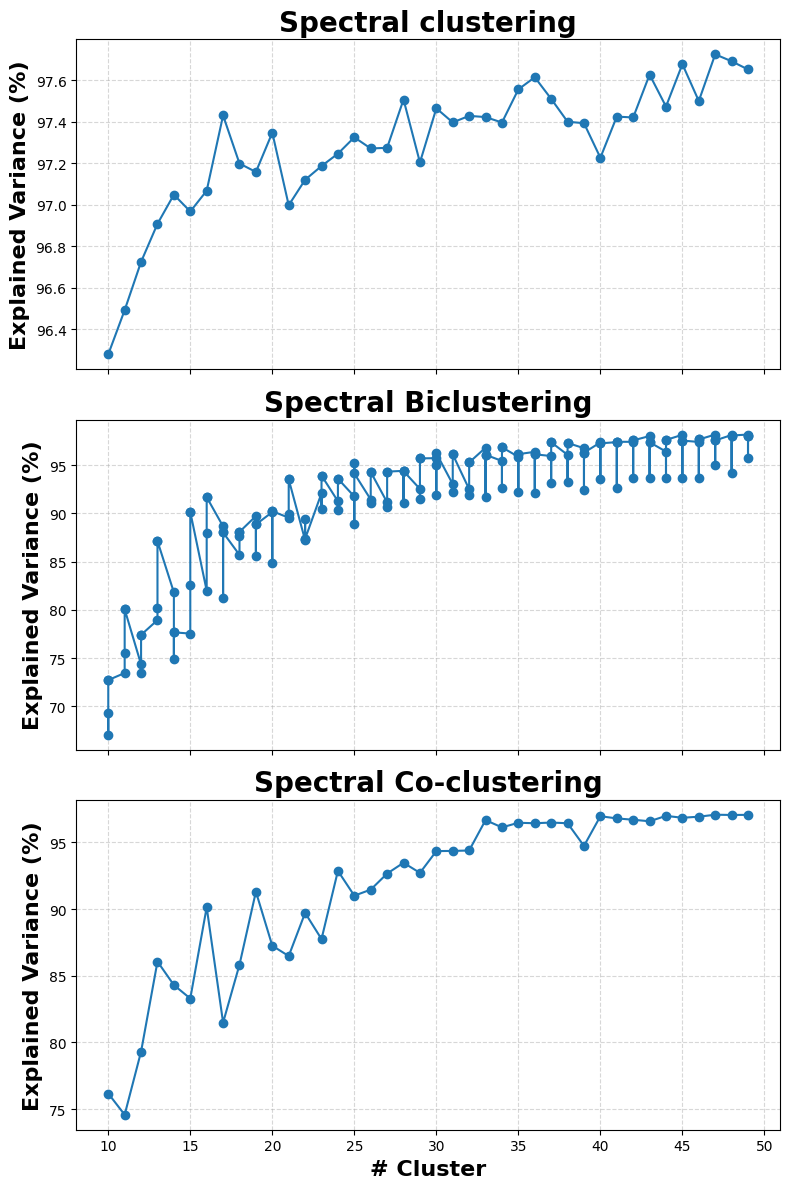

In [38]:
plot_spectral_clustering_elbows([results_spectral_clustering, results_spectral_biclustering, results_spectral_coclustering], 
                                titles=["Spectral clustering", 
                                        "Spectral Biclustering", 
                                        "Spectral Co-clustering"], 
                                fn="../output/figures/20250607_spectral_clustering_elbow.tiff")

    

In [ ]:
results_df = compute_gdkm_cv_scores(
    X,
    P_range=range(20, 30),   # Try 2 to 7 row clusters
    Q_range=range(20, 30),   # Try 2 to 7 column clusters
    cv_folds=3             # 3-fold CV
)

In [23]:
# With BIC-like penalty (favors simpler models)
best_pq, best_score = suggest_optimal_pq(results_df, criterion='bic', penalty_lambda=0.5)
print(f"Best (P, Q) by penalized loss: {best_pq} → score = {best_score:.3f}")

Best (P, Q) by penalized loss: (2, 4) → score = 210.768


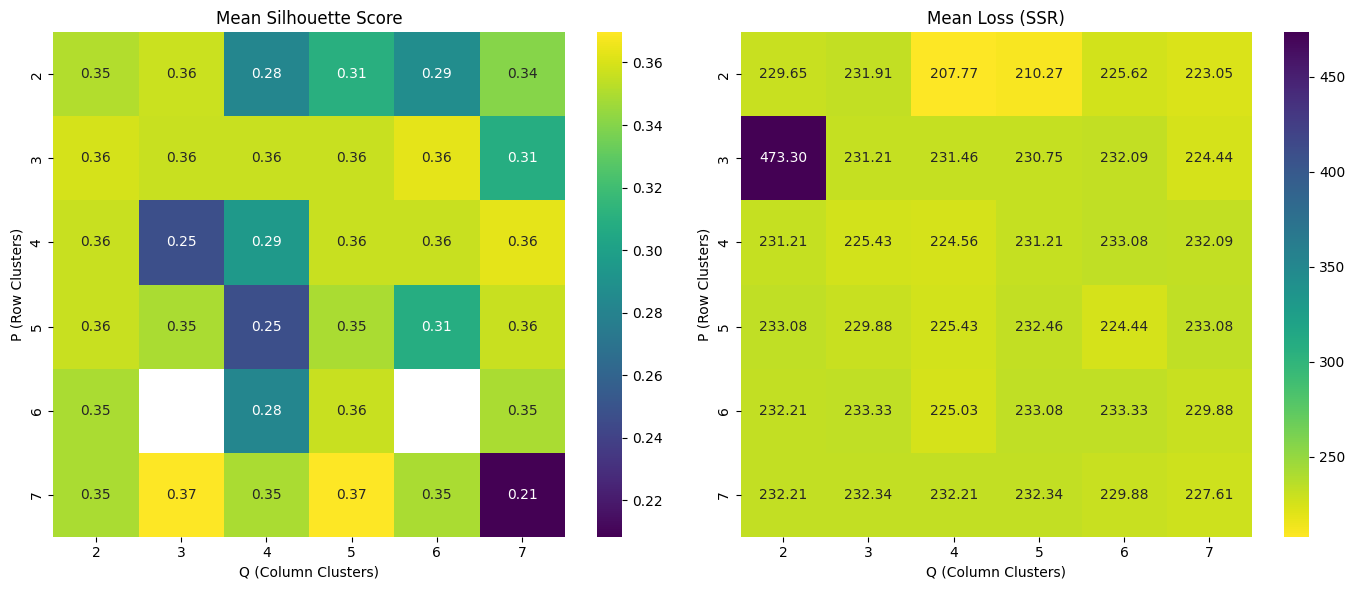

In [24]:
visualize_gdkm_cv_scores(results_df)

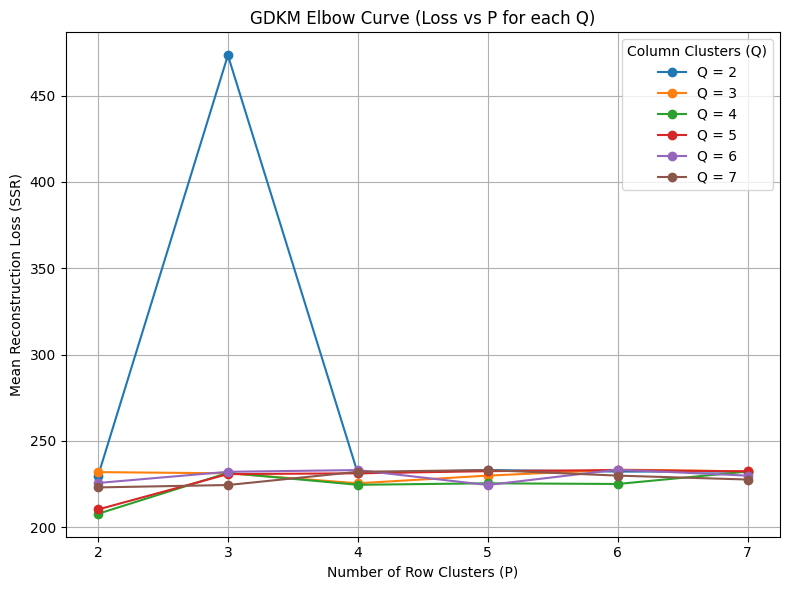

In [25]:
plot_gdkm_elbow_curve(results_df)

In [ ]:

U, V_list, C_blocks, _ = generalized_double_kmeans(
    X, P=4, Q_list=[5]*4, random_state=42
)

visualize_clustered_matrix(X, U, V_list, title="Sales Time-Series Clustering (Preprocessed)")
